This notebook will walk through the reason that it is necessary to model response times, and the various ways to model them. We will start by generating a design that has trials that vary in reaction time.  This is adapted from Poldrack (2014, Developmental Cognitive Neuroscience).

In [13]:
import numpy
import nibabel
from nipy.modalities.fmri.hemodynamic_models import spm_hrf,compute_regressor
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.nonparametric.smoothers_lowess
import scipy
import nipype.algorithms.modelgen as model   # model generation
from nipype.interfaces.base import Bunch
from  nipype.interfaces import fsl
from statsmodels.tsa.arima_process import arma_generate_sample
import os,shutil
from IPython.display import display, HTML
import seaborn as sns
sns.set_style("white")

from nipype.caching import Memory
mem = Memory(base_dir='.')

def clearmem():
    for root, dirs, files in os.walk(mem.base_dir):
        for f in files:
            os.unlink(os.path.join(root, f))
        for d in dirs:
            shutil.rmtree(os.path.join(root, d))
    
# generate the design at a higher temporal resolution
tr=0.1


First generate a design with four events that differ in their duration (by turning on the function for inreasing amounts of time).

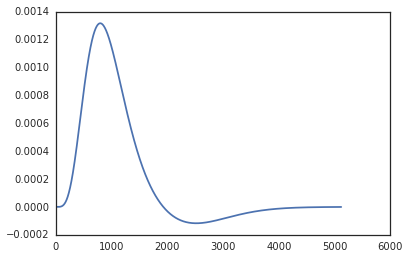

In [14]:
plt.plot(spm_hrf(tr))

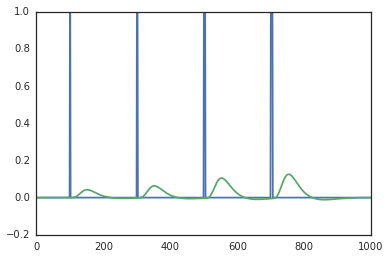

In [15]:
variable_sf=numpy.zeros(1000)

variable_sf[100:102]=1
variable_sf[300:303]=1
variable_sf[500:505]=1
variable_sf[700:706]=1
plt.plot(variable_sf)
variable_sf_conv=numpy.convolve(variable_sf,
                                spm_hrf(tr,oversampling=1))[0:len(variable_sf)]
plt.plot(variable_sf_conv)

This effect tapers off for trials longer than the HRF

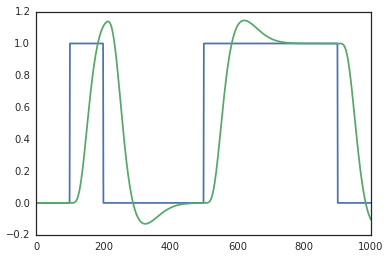

In [16]:
variable_sf_long=numpy.zeros(1000)

variable_sf_long[100:200]=1
variable_sf_long[500:900]=1
plt.plot(variable_sf_long)
variable_sf_long_conv=numpy.convolve(variable_sf_long,
                                spm_hrf(tr,oversampling=1))[0:len(variable_sf)]
plt.plot(variable_sf_long_conv)

Generate a beta-series design matrix that fits a separate regressor for each of the four trials; this is equivalent to separately modeling the intensity of each trial (assuming a constant duration for each).

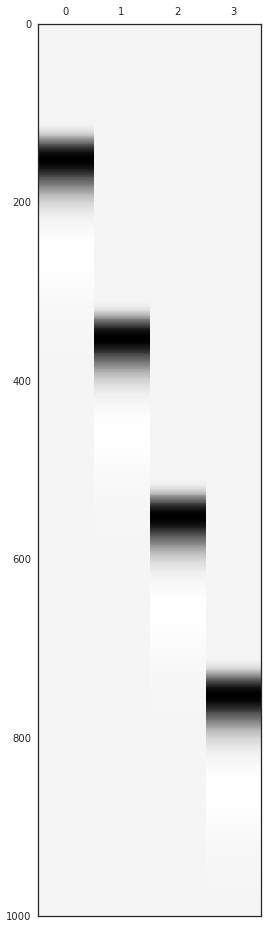

In [17]:
hrf_bases=numpy.zeros((1000,4))
hrf_bases[100:104,0]=1
hrf_bases[300:304,1]=1
hrf_bases[500:504,2]=1
hrf_bases[700:704,3]=1
desmtx=numpy.zeros((1000,4))

for x in range(4):
    desmtx[:,x]=numpy.convolve(hrf_bases[:,x],
                               spm_hrf(tr,oversampling=1))[0:len(variable_sf)]
    
plt.matshow(desmtx, aspect='auto')

Now fit the beta-series model, and generate the fitted regressor.

In [18]:
b_est=numpy.linalg.inv(desmtx.T.dot(desmtx)).dot(desmtx.T).dot(variable_sf_conv)
print b_est
intensity_sf_conv=desmtx.dot(b_est)

[ 0.49983339  0.75066616  1.25010289  1.49736792]


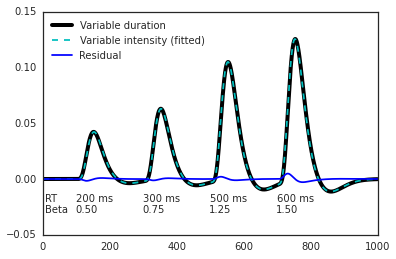

In [19]:
plt.clf()
plt.plot(variable_sf_conv,color='k',linewidth=4)
plt.hold(True)
plt.plot(intensity_sf_conv,'c--')
#plt.plot(constant_sf_conv,color='b')
plt.plot(intensity_sf_conv - variable_sf_conv,color='b')
plt.text(10,-0.02,'RT')
plt.text(100,-0.02,'200 ms')
plt.text(300,-0.02,'300 ms')
plt.text(500,-0.02,'500 ms')
plt.text(700,-0.02,'600 ms')
plt.text(10,-0.03,'Beta')
plt.text(100,-0.03,'%0.2f'%b_est[0])
plt.text(300,-0.03,'%0.2f'%b_est[1])
plt.text(500,-0.03,'%0.2f'%b_est[2])
plt.text(700,-0.03,'%0.2f'%b_est[3])

plt.axis([0,1000,-0.05,0.15])
plt.legend(['Variable duration','Variable intensity (fitted)','Residual'],
           loc='upper left')

The point to take away from this is that the variable duration and variable intensity have largely indistinguishable effects on the hemodynamic response, at least for relatively short events.

###Modeling reaction times

Now let's look at the various ways that one can model response times. First let's generate a design with two conditions that differ in mean response times. We will use a lognormal distribution which is a reasonable approximation to the shape of RT distributions.

Mean RT (condition 0): 0.966605949186
Mean RT (condition 1): 1.84360765021


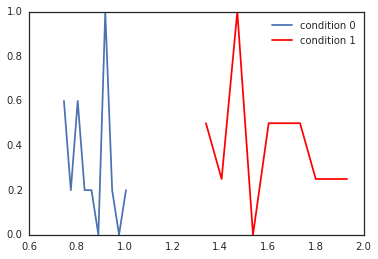

In [20]:
diff=0.5 # difference in RT across conditions
ntrials=32 #  trials per condition
condition=numpy.zeros(ntrials)
condition[ntrials/2:]=1 
rt=numpy.zeros(len(condition))
rt[condition==0]=numpy.random.lognormal(0.0,0.2,ntrials/2)
rt[condition==1]=numpy.random.lognormal(diff,0.2,ntrials/2)

#rt[:ntrials/2]+=rtdiff
h1=numpy.histogram(rt[condition==0])
plt.plot((h1[1][1:]+h1[1][:1])/2.0,h1[0]/float(numpy.max(h1[0])))
h2=numpy.histogram(rt[condition==1])
plt.plot((h2[1][1:]+h2[1][:1])/2.0,h2[0]/float(numpy.max(h2[0])),color='red')
print 'Mean RT (condition 0):',numpy.mean(rt[condition==0])
print 'Mean RT (condition 1):',numpy.mean(rt[condition==1])
plt.legend(['condition 0','condition 1'])
meanrt=numpy.mean(rt)

# generate random onsets

trial_length=16 # length of each trial, including ISI
total_length=trial_length*ntrials
randonsets=numpy.arange(0,total_length,trial_length)
numpy.random.shuffle(randonsets)
onsets=numpy.zeros(len(randonsets))
onsets[condition==0]=numpy.sort(randonsets[condition==0])
onsets[condition==1]=numpy.sort(randonsets[condition==1])



Now generate the data using these onsets and durations. We will generate three datasets:
* constant event duration and activation across conditions (cd_ca)
* variable event duration but constant activation across conditions (vd_ca)
* constant event duration but variable activation across condition (cd_va)

In [21]:
times=numpy.arange(0,total_length,1/100.)
deslen=len(times) # length of design in high-resolution (10 ms) space
sf_vd_ca=numpy.zeros(deslen) 
sf_cd_ca=numpy.zeros(deslen)
sf_cd_va=numpy.zeros(deslen)
activation_effect=1

for i in range(len(onsets)):
    start=onsets[i]*100.
    stop_var=onsets[i]*100 + round(rt[i]*10)
    stop_const=onsets[i]*100 + round(numpy.mean(rt)*10)
    sf_vd_ca[start:stop_var]=1
    sf_cd_ca[start:stop_const]=1
    sf_cd_va[start:stop_const]=1+condition[i]*activation_effect # add activation effect

noiselevel=0.25
noise=arma_generate_sample([1,0.4],[1,0.],total_length)*noiselevel

conv_sf_vd_ca=numpy.convolve(sf_vd_ca,spm_hrf(tr=0.01,oversampling=1.))[:len(sf_vd_ca)]
conv_sf_vd_ca=conv_sf_vd_ca[numpy.arange(0,len(conv_sf_vd_ca),100)]
data_vd_ca=conv_sf_vd_ca*50. + noise

conv_sf_cd_ca=numpy.convolve(sf_cd_ca,spm_hrf(tr=0.01,oversampling=1.))[:len(sf_cd_ca)]
conv_sf_cd_ca=conv_sf_cd_ca[numpy.arange(0,len(conv_sf_cd_ca),100)]
data_cd_ca=conv_sf_cd_ca*50. + noise

conv_sf_cd_va=numpy.convolve(sf_cd_va,spm_hrf(tr=0.01,oversampling=1.))[:len(sf_cd_va)]
conv_sf_cd_va=conv_sf_cd_va[numpy.arange(0,len(conv_sf_cd_va),100)]
data_cd_va=conv_sf_cd_va*50. + noise



(0, 2.2)

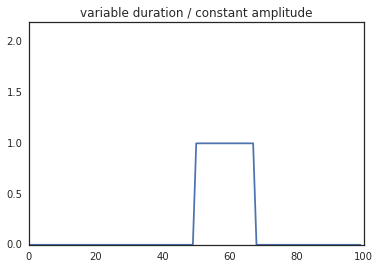

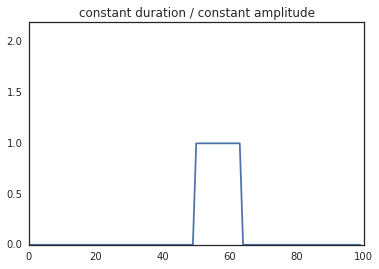

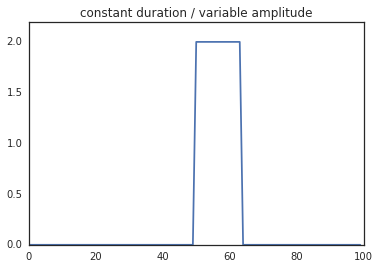

In [57]:
plt.figure()
plt.plot(sf_vd_ca[1550:1650])
plt.ylim([0,2.2])
plt.title("variable duration / constant amplitude")
plt.figure()
plt.plot(sf_cd_ca[1550:1650])
plt.title("constant duration / constant amplitude")
plt.ylim([0,2.2])
plt.figure()
plt.plot(sf_cd_va[1550:1650])
plt.title("constant duration / variable amplitude")
plt.ylim([0,2.2])

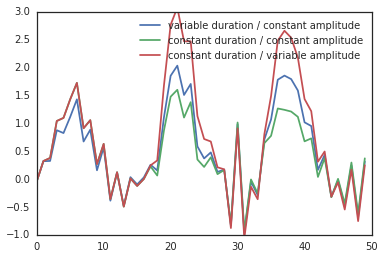

In [72]:
plt.figure()
plt.plot(data_vd_ca[:50], label="variable duration / constant amplitude")
plt.plot(data_cd_ca[:50], label="constant duration / constant amplitude")
plt.plot(data_cd_va[:50], label="constant duration / variable amplitude")
plt.ylim([-1,3])
plt.legend()

In [ ]:
plot

First, build a model that assumes constant event durations

In [100]:
info = [Bunch(conditions=['cond0',
                          'cond1'],
              onsets=[numpy.sort(onsets[condition==0]),
                      numpy.sort(onsets[condition==1])],
              durations=[[meanrt],
                         [meanrt]])]

# create a dummy image for SpecifyModel to look at
if not os.path.exists('tmp.nii.gz'):
    dummy=nibabel.Nifti1Image(numpy.zeros((12,12,12,total_length)),numpy.identity(4))
    dummy.to_filename('tmp.nii.gz')

s = model.SpecifyModel()
s.inputs.input_units = 'secs'
s.inputs.functional_runs = 'tmp.nii.gz'
s.inputs.time_repetition = 1.0
s.inputs.high_pass_filter_cutoff = 128.
s.inputs.subject_info = info
specify_model_results = s.run()

clearmem()

level1design = mem.cache(fsl.model.Level1Design)
level1design_results = level1design(interscan_interval = 1.0,
                                    bases = {'dgamma':{'derivs': False}},
                                    session_info = specify_model_results.outputs.session_info,
                                    model_serial_correlations=False)

modelgen = mem.cache(fsl.model.FEATModel)
modelgen_results = modelgen(fsf_file=level1design_results.outputs.fsf_files,
                            ev_files=level1design_results.outputs.ev_files)


INFO:workflow:Executing node d98baca02b6a4a945e09da6c66fe6ce3 in dir: /home/vagrant/fmri-analysis-vm/analysis/RTmodeling/nipype_mem/nipype-interfaces-fsl-model-Level1Design/d98baca02b6a4a945e09da6c66fe6ce3
INFO:workflow:Executing node 031fc1d7e806c5e7a0ee3eb76f06dc87 in dir: /home/vagrant/fmri-analysis-vm/analysis/RTmodeling/nipype_mem/nipype-interfaces-fsl-model-FEATModel/031fc1d7e806c5e7a0ee3eb76f06dc87
INFO:workflow:Running: feat_model run0 


Model with constant event durations


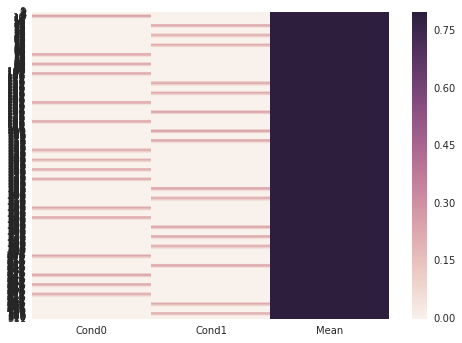

In [101]:
X=numpy.loadtxt(modelgen_results.outputs.design_file,skiprows=5)
X=numpy.hstack((X,numpy.ones((X.shape[0],1))))

print 'Model with constant event durations'

beta_hat_vd_ca_nort=numpy.linalg.inv(X.T.dot(X)).dot(X.T).dot(data_vd_ca)

beta_hat_cd_ca_nort=numpy.linalg.inv(X.T.dot(X)).dot(X.T).dot(data_cd_ca)

beta_hat_cd_va_nort=numpy.linalg.inv(X.T.dot(X)).dot(X.T).dot(data_cd_va)

import pandas as pd
betas_nort=numpy.vstack((beta_hat_vd_ca_nort,beta_hat_cd_ca_nort,beta_hat_cd_va_nort))
df_nort=pd.DataFrame(betas_nort,columns=['Cond0','Cond1','Mean'],
                index=['variable duration/constant amplitude',
                       'constant duration/constant amplitude',
                      'constant duration/variable amplitude'])
HTML( df_nort.to_html() )
import seaborn as sns
sns.heatmap(X, vmin=0, vmax=0.8, xticklabels=df_nort.columns)

Note that the first two datasets have equal activation strengths, and thus their betas should be the same.  

Now build a model using the actual reaction times as regressors.

In [102]:
info = [Bunch(conditions=['cond0',
                          'cond1'],
              onsets=[onsets[condition==0],
                      onsets[condition==1]],
              durations=[rt[condition==0],
                         rt[condition==1]])]

# create a dummy image for SpecifyModel to look at
if not os.path.exists('tmp.nii.gz'):
    dummy=nibabel.Nifti1Image(numpy.zeros((12,12,12,total_length)),numpy.identity(4))
    dummy.to_filename('tmp.nii.gz')
    
s = model.SpecifyModel()
s.inputs.input_units = 'secs'
s.inputs.functional_runs = 'tmp.nii.gz'
s.inputs.time_repetition = 1.0
s.inputs.high_pass_filter_cutoff = 128.
s.inputs.subject_info = info
specify_model_results = s.run()

clearmem()
level1design = mem.cache(fsl.model.Level1Design)
level1design_results = level1design(interscan_interval = 1.0,
                                    bases = {'dgamma':{'derivs': False}},
                                    session_info = specify_model_results.outputs.session_info,
                                    model_serial_correlations=False)

modelgen = mem.cache(fsl.model.FEATModel)
modelgen_results = modelgen(fsf_file=level1design_results.outputs.fsf_files,
                            ev_files=level1design_results.outputs.ev_files)


INFO:workflow:Executing node c33903d6be596d363f166487d420e5b2 in dir: /home/vagrant/fmri-analysis-vm/analysis/RTmodeling/nipype_mem/nipype-interfaces-fsl-model-Level1Design/c33903d6be596d363f166487d420e5b2
INFO:workflow:Executing node dfc8826ad3fbdd0652e8938ebd4ed115 in dir: /home/vagrant/fmri-analysis-vm/analysis/RTmodeling/nipype_mem/nipype-interfaces-fsl-model-FEATModel/dfc8826ad3fbdd0652e8938ebd4ed115
INFO:workflow:Running: feat_model run0 


Model with variable durations


,Cond0,Cond1,Mean
variable duration/constant amplitude,5.063582,5.202939,0.425681
constant duration/constant amplitude,5.454941,4.069297,0.412986
constant duration/variable amplitude,5.394060,8.226239,0.617400


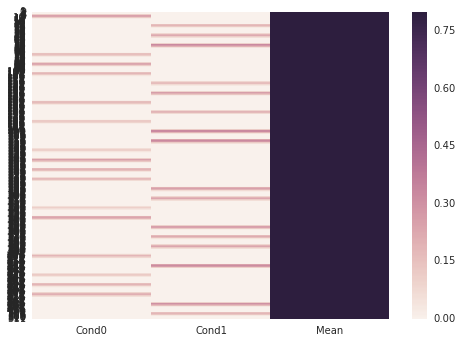

In [97]:
X=numpy.loadtxt(modelgen_results.outputs.design_file,skiprows=5)
X=numpy.hstack((X,numpy.ones((X.shape[0],1))))

print 'Model with variable durations'

beta_hat_vd_ca_rt=numpy.linalg.inv(X.T.dot(X)).dot(X.T).dot(data_vd_ca)
beta_hat_cd_ca_rt=numpy.linalg.inv(X.T.dot(X)).dot(X.T).dot(data_cd_ca)
beta_hat_cd_va_rt=numpy.linalg.inv(X.T.dot(X)).dot(X.T).dot(data_cd_va)

import pandas as pd
betas_varrt=numpy.vstack((beta_hat_vd_ca_rt,beta_hat_cd_ca_rt,beta_hat_cd_va_rt))
df_varrt=pd.DataFrame(betas_varrt,columns=['Cond0','Cond1','Mean'],
                index=['variable duration/constant amplitude',
                       'constant duration/constant amplitude',
                      'constant duration/variable amplitude'])
sns.heatmap(X, vmin=0, vmax=0.8, xticklabels=df_nort.columns)
HTML( df_varrt.to_html() )

There are two thigns to notice here.  First, the RT-unrelated region now has an artifactual difference between conditions, driven by the differences in RT across conditions that are now included in the regressor.  Second, notice that the difference in activation between conditions in the third dataset (where one actually exists) is reduced compared to the previous model, because some of the effect is being removed due to its correlation with the RT difference across conditions.

Now let's build a model that includes a separate parametric regressor for RT alongside the constant duration (unmodulated) regressor.

In [98]:
info = [Bunch(conditions=['cond0-const',
                          'cond1-const',
                         'RT'],
              onsets=[onsets[condition==0],
                      onsets[condition==1],
                     onsets],
              durations=[[meanrt],
                         [meanrt],
                          [meanrt]],
              amplitudes=[[1],[1],rt-meanrt]
                         )]

# create a dummy image for SpecifyModel to look at
dummy=nibabel.Nifti1Image(numpy.zeros((12,12,12,total_length)),numpy.identity(4))
dummy.to_filename('tmp.nii.gz')
s = model.SpecifyModel()
s.inputs.input_units = 'secs'
s.inputs.functional_runs = 'tmp.nii.gz'
s.inputs.time_repetition = 1.0
s.inputs.high_pass_filter_cutoff = 128.
s.inputs.subject_info = info
specify_model_results = s.run()

clearmem()
level1design = mem.cache(fsl.model.Level1Design)
level1design_results = level1design(interscan_interval = 1.0,
                                    bases = {'dgamma':{'derivs': False}},
                                    session_info = specify_model_results.outputs.session_info,
                                    model_serial_correlations=False)

modelgen = mem.cache(fsl.model.FEATModel)
modelgen_results = modelgen(fsf_file=level1design_results.outputs.fsf_files,
                            ev_files=level1design_results.outputs.ev_files)


INFO:workflow:Executing node 208a60e375d834afe9bb9b9c24402e45 in dir: /home/vagrant/fmri-analysis-vm/analysis/RTmodeling/nipype_mem/nipype-interfaces-fsl-model-Level1Design/208a60e375d834afe9bb9b9c24402e45
INFO:workflow:Executing node aafb3abc708a278f016556e5b97fb815 in dir: /home/vagrant/fmri-analysis-vm/analysis/RTmodeling/nipype_mem/nipype-interfaces-fsl-model-FEATModel/aafb3abc708a278f016556e5b97fb815
INFO:workflow:Running: feat_model run0 


Model with parametric RT effect


,Cond0,Cond1,RTparam,Mean
variable duration/constant amplitude,5.133858,5.184455,4.034488,0.425681
constant duration/constant amplitude,4.982697,5.019411,0.111880,0.412986
constant duration/variable amplitude,4.972840,10.102610,0.067268,0.617400


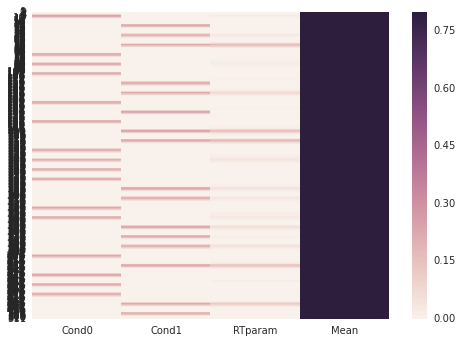

In [99]:
X=numpy.loadtxt(modelgen_results.outputs.design_file,skiprows=5)
X=numpy.hstack((X,numpy.ones((X.shape[0],1))))

print 'Model with parametric RT effect'

beta_hat_vd_ca_param=numpy.linalg.inv(X.T.dot(X)).dot(X.T).dot(data_vd_ca)
beta_hat_cd_ca_param=numpy.linalg.inv(X.T.dot(X)).dot(X.T).dot(data_cd_ca)
beta_hat_cd_va_param=numpy.linalg.inv(X.T.dot(X)).dot(X.T).dot(data_cd_va)


betas_param=numpy.vstack((beta_hat_vd_ca_param,beta_hat_cd_ca_param,beta_hat_cd_va_param))
df_param=pd.DataFrame(betas_param,columns=['Cond0','Cond1','RTparam','Mean'],
                index=['variable duration/constant amplitude',
                       'constant duration/constant amplitude',
                      'constant duration/variable amplitude'])
sns.heatmap(X, vmin=0, vmax=0.8, xticklabels=df_param.columns)
HTML( df_param.to_html() )

Here you see that there are no big diferences between conditions (the first two colums) for the first two datasets, where there was no difference, and the model accurately detected the RT effect for the first dataset.  You also see that the differential activaiton effect is now roughtly as large as it was for the constant duration model, as it should be.